# Age at first live birth


In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter

from utils import decorate
from utils import value_counts
from utils import resample_by_cycle
from utils import round_into_bins
from utils import remove_spines
from utils import set_palette

from empiricaldist import Pmf, Cdf

random_seed = 1

<IPython.core.display.Javascript object>

In [4]:
# Make the figures smaller to save some screen real estate.
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [5, 3.7]

<IPython.core.display.Javascript object>

## Run the analysis with lifelines

Load the data cleaned in `clean_nsfg.ipynb` and run the analysis with `lifelines`

In [5]:
%time unweighted = pd.read_hdf('FemMarriageData.hdf', 'FemMarriageData')
unweighted.shape

CPU times: user 62.1 ms, sys: 12.8 ms, total: 74.9 ms
Wall time: 79.3 ms


(75769, 38)

<IPython.core.display.Javascript object>

In [23]:
trimmed = unweighted["agebaby1"] < 14
unweighted.loc[trimmed, "agebaby1"] = 14

<IPython.core.display.Javascript object>

In [24]:
unweighted["parous"] = unweighted["parity"] > 0
value_counts(unweighted["parous"])

parous
False    32395
True     43374
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [25]:
for name, group in unweighted.groupby("birth_index"):
    missing = group["parous"] & group["agebaby1"].isna()
    print(name, missing.sum())

30 0
40 3
50 2
60 1
70 0
80 0
90 0
100 1


<IPython.core.display.Javascript object>

In [26]:
sample = resample_by_cycle(unweighted)

<IPython.core.display.Javascript object>

In [27]:
value_counts(sample["birth_index"])

birth_index
30       360
40      3973
50     10348
60     15516
70     17959
80     15406
90      9605
100     2602
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [28]:
def drop_missing(df):
    # find people who are parous but have no agebaby1
    missing = df["parous"] & df["agebaby1"].isna()
    return df[~missing]

<IPython.core.display.Javascript object>

In [29]:
def fill_missing(df):
    for cohort in range(30, 110, 10):
        # find people in this cohort who are parous but have no agebaby1
        missing = (df["birth_index"] == cohort) & df["parous"] & df["agebaby1"].isna()
        n = missing.sum()
        if n == 0:
            continue

        # find people in this cohort who have borne at least one child
        donors = (df["birth_index"] == cohort) & df["parous"] & df["agebaby1"].notna()

        # select their ages at first birth
        agebaby1 = df.loc[donors, "agebaby1"]
        low, high = np.percentile(agebaby1, [1, 99])
        index = agebaby1.between(low, high)

        # fill missing data with a random sample
        sample = np.random.choice(agebaby1[index], size=n, replace=True)
        df.loc[missing, "agebaby1"] = sample

<IPython.core.display.Javascript object>

In [30]:
# fill_missing(sample)
sample = drop_missing(sample)

missing = sample["parous"] & sample["agebaby1"].isna()
missing.sum()

0

<IPython.core.display.Javascript object>

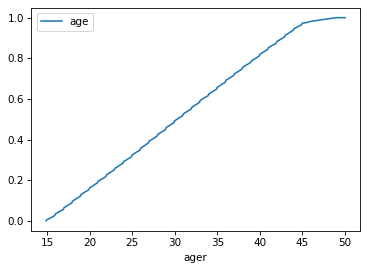

<IPython.core.display.Javascript object>

In [31]:
cdf = Cdf.from_seq(sample["ager"], name="age")
cdf.plot()
decorate()

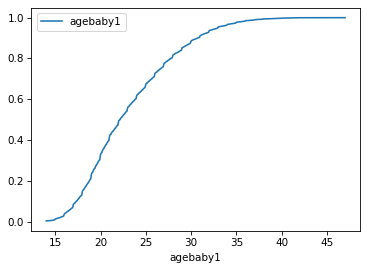

<IPython.core.display.Javascript object>

In [32]:
cdf = Cdf.from_seq(sample["agebaby1"], name="agebaby1")
cdf.plot()
decorate()

In [33]:
from utils import make_kmf_map

<IPython.core.display.Javascript object>

In [34]:
parous = sample["parous"]
sample["observed"] = parous
sample.loc[parous, "duration"] = sample["agebaby1"]
sample.loc[~parous, "duration"] = sample["ager"]

<IPython.core.display.Javascript object>

In [35]:
grouped = sample.groupby("birth_index")
nsfg_map = make_kmf_map(grouped)

<IPython.core.display.Javascript object>

In [36]:
from utils import add_text

<IPython.core.display.Javascript object>

In [37]:
def make_title(title, subtitle, pad=30):
    plt.title(title, loc="left", pad=pad)
    add_text(0, 1.085, subtitle)
    add_text(0, 1.015, "Analysis: allendowney.com/blog")

<IPython.core.display.Javascript object>

In [38]:
def decorate_plot(**options):
    decorate(
        xlabel="Age",
        ylabel="Percent",
        xlim=[13, 55],
        **options,
    )
    title = "Percent who have borne a child, by decade of birth"
    subtitle = "Data: NSFG 1982-2023 "
    make_title(title, subtitle)

<IPython.core.display.Javascript object>

In [39]:
def plot_kmf_map(ax, kmf_map, cohorts, add_label=True, **options):
    """ """
    palette = set_palette("hls", len(cohorts))
    for cohort in cohorts:
        series = kmf_map[cohort]
        label = f"{cohort+1900}s" if add_label else ""
        series.plot(ax=ax, label=label, **options)
        label = ""

<IPython.core.display.Javascript object>

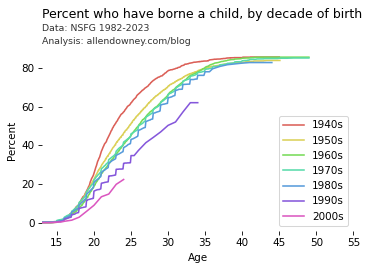

<IPython.core.display.Javascript object>

In [61]:
cohorts = range(40, 110, 10)

fig, ax = plt.subplots()
plot_kmf_map(ax, nsfg_map, cohorts)
decorate_plot()
remove_spines()
plt.tight_layout()

In [62]:
kmf_series = {}

for i in range(21):
    sample = resample_by_cycle(unweighted)
    # fill_missing(sample)
    sample = drop_missing(sample)
    parous = sample["parous"]
    sample["observed"] = parous
    sample.loc[parous, "duration"] = sample["agebaby1"]
    sample.loc[~parous, "duration"] = sample["ager"]
    grouped = sample.groupby("birth_index")
    kmf_map = make_kmf_map(grouped)
    for cohort in kmf_map:
        kmf_series.setdefault(cohort, []).append(kmf_map[cohort])

<IPython.core.display.Javascript object>

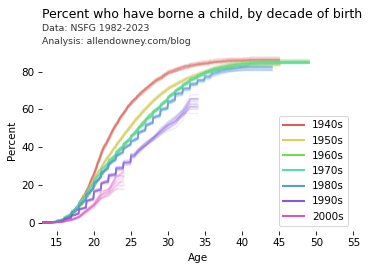

<IPython.core.display.Javascript object>

In [63]:
palette = sns.color_palette("hls", len(cohorts))
options = dict(alpha=0.1)
xnudge = {40: -20, 50: -20}
ynudge = {40: -7, 50: -15, 60: 2, 70: -2}

for i, cohort in enumerate(cohorts):
    label = f"{cohort+1900}s"
    series_list = kmf_series[cohort]
    coords = []
    for series in series_list:
        coords.append((series.index[-1], series.iloc[-1]))
        series.plot(label=label, color=palette[i], **options)
        label = ""

    xs, ys = np.transpose(coords)
    x = xs.max() + xnudge.get(cohort, 0.2)
    y = ys.mean() + ynudge.get(cohort, 0)
    text = f"{1900+cohort}s"
    # plt.text(x, y, text, va="center")


decorate_plot()
legend = plt.gca().legend()
for line in legend.get_lines():
    line.set_alpha(1)  # Set transparency
    line.set_linewidth(2)  # Set line width


remove_spines()
plt.tight_layout()
plt.savefig("borne23.jpg", dpi=300)